# Dynamic Programming - Value Iteration 

2020 Jérémie Decock

[![My Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gl/jdhp%2Fslides-rl/HEAD?filepath=labs%2Flab_rl3_value_iteration.ipynb)

[![NbViewer](https://raw.githubusercontent.com/jupyter/design/master/logos/Badges/nbviewer_badge.svg)](https://nbviewer.jupyter.org/urls/gitlab.com/jdhp/slides-rl/-/raw/master/labs/lab_rl3_value_iteration.ipynb/%3Finline%3Dfalse)

[![Local](https://img.shields.io/badge/Local-Save%20As...-blue)](https://gitlab.com/jdhp/slides-rl/-/raw/master/labs/lab_rl3_value_iteration.ipynb?inline=false)

## Introduction

The purpose of this lab is to introduce some classic concepts used
in reinforcement learning like *Dynamic Programming*, *Bellman's Principle of Optimality*, *Bellman equations* and the *Value Iteration* algorithm.
$
\newcommand{\vs}[1]{\mathbf{#1}} % vector symbol (\boldsymbol, \textbf or \vec)
\newcommand{\ms}[1]{\mathbf{#1}} % matrix symbol (\boldsymbol, \textbf)
\def\U{V}
\def\action{\vs{a}}       % action
\def\A{\mathcal{A}}        % TODO
\def\actionset{\mathcal{A}} %%%
\def\discount{\gamma}  % discount factor
\def\state{\vs{s}}         % state
\def\S{\mathcal{S}}         % TODO
\def\stateset{\mathcal{S}}  %%%
$

**Notice**: Here we assume that the reward **only depends on the state**: $r(\state) \equiv \mathcal{R}(\state, \action, \state')$.

**Notice**: this notebook requires the OpenAI *Gym* library ; you can install it with `pip install gym` (the next cell does this for you if you use the Google Colab environment).

In [1]:
colab_requirements = [
    "matplotlib>=3.1.2",
    "numpy>=1.18.1",
    "nose>=1.3.7",
    "gym=>0.15.4",
]
import sys, subprocess
def run_subprocess_command(cmd):
    # run the command
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    # print the output
    for line in process.stdout:
        print(line.decode().strip())
        
if "google.colab" in sys.modules:
    for i in colab_requirements:
        run_subprocess_command("pip install " + i)

You can uncomment the following cell to install gym in MyBinder or in your local environment (remove only the `#` not the `!`).

In [2]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

import math
import gym
import numpy as np
import copy
import pandas as pd
import seaborn as sns

In [3]:
sns.set_context("talk")

In [4]:
#matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

## Backward Induction

*Backward Induction* is a basic *Dynamic Programming* method **[BELLMAN57]**.
Like other Dynamic Programming algorithms, it uses the *Bellman's
Principle of Optimality* **[BELLMAN57]** for accelerating computation (compared
to an exhaustive search). It can be applied to problems that exhibit a compatible structure, i.e., a problem that has *overlapping subproblems* or a problem having an *optimal substructure* **[BELLMAN57]**.
Actually, this acceleration is obtained by breaking problems down into simpler subproblems in such a manner
that redundant computations are avoided by storing results.
When applicable, the method takes far less time than naïve methods that don't take advantage of the subproblem overlap (like depth-first search).

*Backward Induction* computes non-stationary policies: a new policy is computed for each time step.
Thus the number of time steps used to solve the problem is set in advance.
*Backward Induction* algorithms solve Sequential Decision Making problems defined with
discrete actions and state spaces.

The *value* (or *utility*) $\U^*$ for each state $\state$ at the latest time step $T$ is
$$
\U^*_T(\state) = r(\state) \label{eq:backward-induction-last-value} \tag{1}
$$
where $r$ is the immediate reward function.

The best expected value $\U^*$ for each state $\state$ at the $t^{\text{th}}$ time step is
$$
\U^*_t(\state) = r(\state) + \max_{\action \in \actionset} \left[ \sum_{\state' \in \stateset} P(\state' | \state, \action) \U^*_{t+1}(\state') \right]  \label{eq:backward-induction-tth-value} \tag{2}
$$
and the $t^{\text{th}}$ optimal action (or decision) $d^*_t(\state)$ among the set of
possible actions $\actionset$ is
$$
d^*_t(\state) = \arg\max_{\action \in \actionset} \left[ \sum_{\state' \in \stateset} P(\state' | \state, \action) \U^*_{t+1}(\state') \right]  \label{eq:backward-induction-tth-decision} \tag{3}
$$
where $T$ is the transition function.

The main idea is to compute the expected value of each state
(Eq. \ref{eq:backward-induction-tth-value}) and then to use it to select the
best action for any given state (Eq. \ref{eq:backward-induction-tth-decision}).

Eq. \ref{eq:backward-induction-tth-value} cannot be solved analytically because
the system of equations to compute $V$ contains non-linear terms (due to the
"max" operator).
As an alternative, Eq. \ref{eq:backward-induction-tth-value}
is usually computed using Dynamic Programming method, as described in algorithm 1.

___
### Algorithm 1: Backward Induction

**Input**:<br>
$\quad$ $mdp = \langle \stateset, \actionset, T, r \rangle$, a Markov Decision Process <br>
$\quad$ $T$, the resolution horizon (i.e. the number of time steps) <br>
**Local variables**: <br>
$\quad$ $\U^*_t ~~ \forall t \in \{1, ..., T\}$, vectors of utilities for states in $\stateset$ <br>
<br>
$\U^*_T[\state] \leftarrow r(\state) ~~ \forall \state \in \stateset$ <br>
**for all** $t \in \{T-1, T-2, ..., 1\}$ **do** <br>
$\quad$ **for all** $\state \in \stateset$ **do** <br>
$\quad\quad$ **if** $\state$ is a final state **then** <br>
$\quad\quad\quad$ $\displaystyle \U^*_t[\state] \leftarrow r(\state)$ <br>
$\quad\quad$ **else** <br>
$\quad\quad\quad$ $\displaystyle \U^*_t[\state] \leftarrow r(\state) + \max_{\action \in \actionset} \left[ \sum_{\state' \in \stateset} P(\state' | \state, \action) \U^*_{t+1}[\state'] \right]$ <br>
$\quad\quad$ **end if** <br>
$\quad$ **end for** <br>
**end for** <br>
<br>
**return** $\U^*_t ~~ \forall t \in \{1, ..., T\}$
___

## Value Iteration

*Value Iteration* **[BELLMAN57]** is one of the most famous Dynamic Programming algorithm to compute the optimal policy for a Markov Decision Process (MDP).
Similarly to Backward Induction, the
main idea implemented by Value Iteration is to compute the best expected value of each state and then to use
these values to select the best action from any given state.

The main difference with the Backward Induction algorithm is that Value Iteration
is used to compute stationary policies.
Indeed, the same resulting policy is used for each time step and thus there is
no assumption about the number of time steps to consider for the solution.

The expected value $\U^{\pi}$ for each state $\state$ when the agent follows a
given (stationary) policy $\pi$ is 
$$
\U^{\pi}(\state) = E \left[ \sum^{\infty}_{t=0} \discount^t r(\state_t) | \pi, \state_0 = \state \right] \label{eq:vi-value-of-s-for-pi} \tag{4}
$$

The optimal (stationary) policy $\pi^*$ is defined using the best expected value $\U^{\pi^*}$ and using the principle of *Maximum Expected Utility* as follows
$$
\pi^*(\state) = \arg\max_{\action \in \actionset} \left[ \sum_{\state' \in \stateset} P(\state' | \state, \action) \U^{\pi^*}(\state') \right]  \label{eq:vi-optimal-policy} \tag{5}
$$

Eq. \ref{eq:vi-bellman-eq} is commonly called *Bellman equation*; it gives the best
value we can expect for any given
state (assuming the optimal policy $\pi^*$ is
followed). There are $|\stateset|$ Bellman equations, one for each state.
As for the Backward Induction method,
this system of equations cannot be solved analytically because
Bellman equations contain non-linear terms (due to the
"max" operator).  As an alternative, Eq. \ref{eq:vi-bellman-eq}
can be computed iteratively using Value Iteration, a Dynamic Programming method
described in Algorithm 2.

\begin{equation}
    \U(\state) := \U^{\pi^*}(\state) = \left\{
    \begin{array}{l l}
        r(\state)                                                                                                                                 & \quad \text{if $\state$ is a final state} \\
        \displaystyle r(\state) + \discount \max_{\action \in \actionset} \left[ \sum_{\state' \in \stateset} P(\state' | \state, \action) \U(\state') \right]    & \quad \text{otherwise}\\
    \end{array} \right.
    \label{eq:vi-bellman-eq} \tag{6}
\end{equation}

Equation \ref{eq:vi-bellman-update} -- called *Bellman update* -- is
used in the iterative method described in Algorithm 2, to update $\U$ at each iteration.

\begin{equation}
    \U_{i+1}(\state) \leftarrow \left\{
    \begin{array}{l l}
        r(\state)                                                                                                                                   & \quad \text{if $\state$ is a final state} \\
        \displaystyle r(\state) + \discount \max_{\action \in \actionset} \left[ \sum_{\state' \in \stateset} P(\state' | \state, \action) \U_i(\state') \right]    & \quad \text{otherwise}\\
    \end{array} \right.
    \label{eq:vi-bellman-update} \tag{7}
\end{equation}

___
### Algorithm 2: Value Iteration

**Input**:<br>
$\quad$ $mdp = \langle \stateset, \actionset, P, r \rangle$, a Markov Decision Process <br>
$\quad$ $\discount$, the discount factor <br>
$\quad$ $\epsilon$, the maximum error allowed in the utility of any state in an iteration <br>
**Local variables**: <br>
$\quad$ $\U, \U'$, old and new vectors of utilities for states in $\stateset$, initially zero <br>
$\quad$ $\delta$, the maximum change in the utility of any state in an iteration <br>
<br>
**repeat** <br>
$\quad$ $\U \leftarrow \U'$ <br>
$\quad$ $\delta \leftarrow 0$ <br>
$\quad$ **for all** $\state \in \stateset$ **do** <br>
$\quad\quad$ **if** $\state$ is a final state **then** <br>
$\quad\quad\quad$ $\displaystyle \U'[\state] \leftarrow r[\state]$ <br>
$\quad\quad$ **else** <br>
$\quad\quad\quad$ $\displaystyle \U'[\state] \leftarrow r[\state] + \discount \max_{\action \in \actionset} \left[ \sum_{\state' \in \stateset} P(\state' | \state, \action) \U[\state'] \right]$ <br>
$\quad\quad$ **end if** <br>
$\quad\quad$ **if** $|\U'[\state] - \U[\state]| > \delta$ **then** <br>
$\quad\quad\quad$ $\delta \leftarrow |\U'[\state] - \U[\state]|$ <br>
$\quad\quad$ **end if** <br>
$\quad$ **end for** <br>
**until** $\delta < \epsilon(1-\discount)/\discount$ <br>
<br>
**return** $\U$
___

### Convergence

The convergence of Value Iteration has been proved, but this convergence is asymptotic **[BELLMAN57]**.
However, each iteration is easy and fast to compute.

## Hands on OpenAI Gym and the FrozenLake toy problem

For the purpose of focusing on the algorithms, we will use standard environments provided by OpenAI Gym framework.
OpenAI Gym provides controllable environments (https://gym.openai.com/envs/) for research in Reinforcement Learning.
We will use a simple toy problem to illustrate Dynamic Programming algorithms properties.

**Task:** read https://gym.openai.com/docs/ to discover Gym and get familiar with its main concepts.

In this lab, we will try to solve the FrozenLake-v0 environment (https://gym.openai.com/envs/FrozenLake-v0/).
Additional information is available [here](https://github.com/openai/gym/wiki/FrozenLake-v0) and [here](https://github.com/openai/gym/wiki/FrozenLake-v0).

**Notice**: this environment is *fully observable*, thus here the terms (environment) *state* and (agent) *observation* are equivalent.
This is not always the case for example in poker, the agent doesn't know the opponent's cards.

### Get the FrozenLake state space and action space

In [5]:
env = gym.make('FrozenLake-v0')

Possible states in FrozenLake are:

In [6]:
states = list(range(env.observation_space.n))
states

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]

Possible actions are:

In [7]:
actions = list(range(env.action_space.n))
actions

[0, 1, 2, 3]

The following dictionary may be used to understand actions:

In [8]:
action_labels = {
    0: "Move Left",
    1: "Move Down",
    2: "Move Right",
    3: "Move Up"
}

### Display functions

The next cells contain functions that can be used to display states, transitions and policies with the FrozenLake environment.

In [9]:
def states_display(state_seq, title=None, figsize=(5,5), annot=True, fmt="0.1f", linewidths=.5, square=True, cbar=False, cmap="Reds"):
    size = int(math.sqrt(len(state_seq))) #the length of one side
    state_array = np.array(state_seq)
    state_array = state_array.reshape(size, size) # reshape state_array to size*size, the square
    
    fig, ax = plt.subplots(figsize=figsize)         # Sample figsize in inches
    sns.heatmap(state_array, annot=annot, fmt=fmt, linewidths=linewidths, square=square, cbar=cbar, cmap=cmap)
    plt.title(title)
    plt.show()

In [10]:
def transition_display(state, action):
    states_display(transition_array[state,action], title="Transition probabilities for action {} ({}) in state {}".format(action, action_labels[action], state))

In [11]:
def display_policy(policy):
    actions_src = ["{}={}".format(action, action_labels[action].replace("Move ", "")) for action in actions]
    title = "Policy (" + ", ".join(actions_src) + ")"
    states_display(policy, title=title, fmt="d", cbar=False, cmap="Reds")

### Make the `is_final_array`, `reward_array` and `transition_array`

To implement Dynamic Programming algorithms, we need the transition probability (or transition function) and the reward function, both defined in `env.P`.

`env.P[S][A]` gives the list of reachable states from state S executing action A.

These reachable states are coded in a tuple defined like this: `(probability, next state, reward, is_final_state)`.

You will not need to use `env.P` to solve exercises.
In the following cell, `is_final_array`, `reward_array` and `transition_array` are defined for convenience.

In [12]:
is_final_array = np.full(shape=len(states), fill_value=np.nan, dtype=np.bool)
reward_array = np.full(shape=len(states), fill_value=np.NINF)                # np.NINF = negative infinity
transition_array = np.zeros(shape=(len(states), len(actions), len(states)))

for state in states:
    for action in actions:
        for next_state_tuple in env.P[state][action]:              # env.P[state][action] contains the next states list (a list of tuples)
            transition_probability, next_state, next_state_reward, next_state_is_final = next_state_tuple

            is_final_array[next_state] = next_state_is_final
            reward_array[next_state] = max(reward_array[next_state], next_state_reward)   # workaround: when we already are in state 15, reward is 0 if we stay in state 15 (in practice this never append as the simulation stop when we arrive in state 15 as any other terminal state)
            transition_array[state, action, next_state] += transition_probability

In [13]:
def reachable_states(state, action):
    return np.nonzero(transition_array[state, action])[0]

The following plot shows the state corresponding to square of the FrozenLake grid.

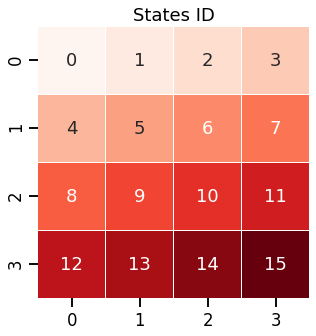

In [14]:
states_display(states, fmt="d", title="States ID")

The following plot shows the reward obtained in each square of the FrozenLake grid.

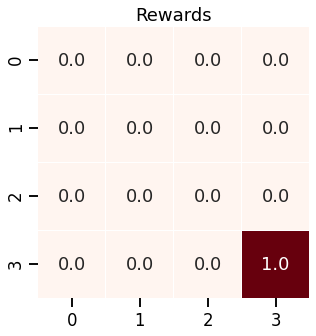

In [15]:
states_display(reward_array, title="Rewards")

The following plot shows whether a square is a final state or not (i.e. whether it ends the simulation or not).

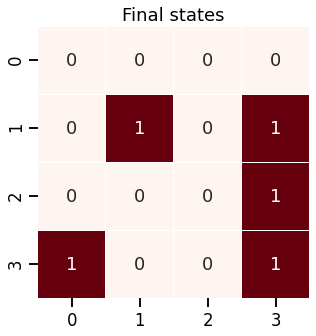

In [16]:
states_display(is_final_array, fmt="d", title="Final states")

The following cells show how to display transitions with the provided `transition_display` function. Figures displayed in squares are the probability to reach these squares from the given (`state`, `action`) pair. Colored squares are the states that may be reached from this pair (a non-zero probability).

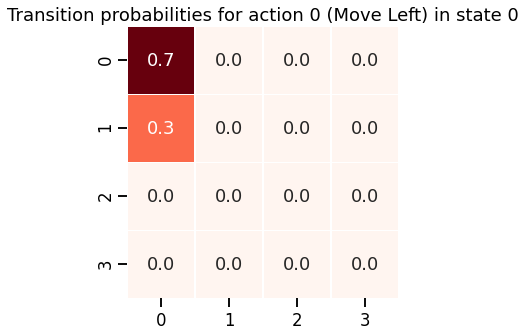

In [17]:
transition_display(state=0, action=0)

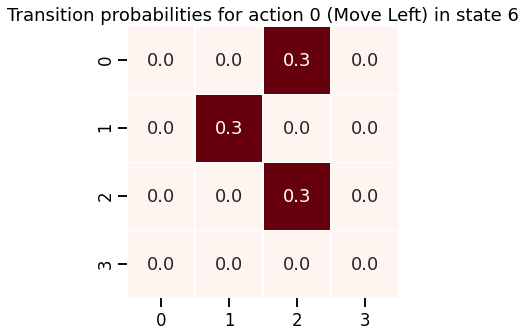

In [18]:
transition_display(state=6, action=0)

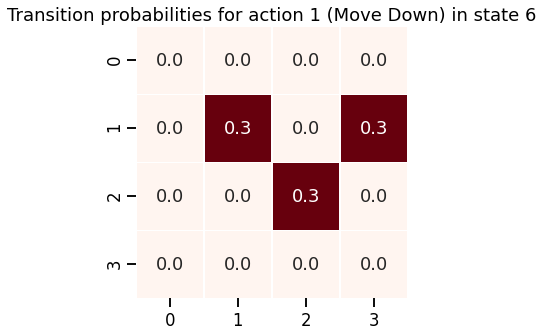

In [19]:
transition_display(state=6, action=1)

## Exercise 1: Implement the Value Iteration algorithm

To solve the FrozenLake-v0 problem with Dynamic Programming, we will first use the Value Iteration algorithm described in Algorithm 2.

Notice that the FrozenLake-v0 environment is non-deterministic.
To implement Value Iteration, you will need the transition probability (or the transition function) defined in `transition_array`.
- Use `reachable_states(S, A)` to get the list of reachable states from state `S` executing action `A`.
- Use `transition_array[S, A]` to get the probability of reaching each state from state `S` executing action `A`.
- Use `transition_array[S, A, S']` to get the probability of reaching state `S'` from state `S` executing action `A`.

You will also need the previously defined `is_final_array` matrix.
- Use `is_final_array[S]` to know whether `S` is a final state (`True`) or not (`False`).

Finally, you will need the previously defined `reward_array` matrix.
- Use `reward_array[S]` to get the reward obtained by the agent each time it reaches state `S`.

In the following cell, we define `expected_value` and `expected_values` functions for convenience.
The first one returns the expected reward
$$\sum P(\state' | \state, \action) \U(\state')$$
for a given pair $(\state, \action)$ and a given V-table (value function) $\U$.
The second one computes the expected reward for all the actions in $\state$.

In [20]:
def expected_value(state, action, v_array):
    return (transition_array[state, action] * v_array).sum() # compute sum(P(s'|a,s).V(s'))

In [21]:
def expected_values(state, v_array):
    return (transition_array[state] * v_array).sum(axis=1)   # compute sum(P(s'|a,s).V(s')) for all the actions

### Question 1: Implement the Value Iteration algorithm (compute the *value function* `v_array`)

**Note**: here we use the `state_display` function to show the evolution of the value function `v_array` over iterations.

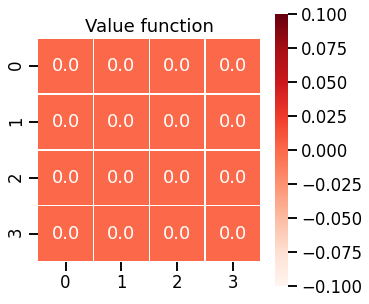

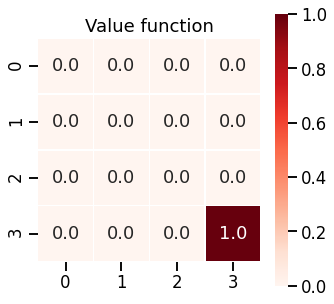

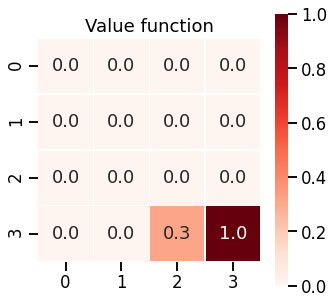

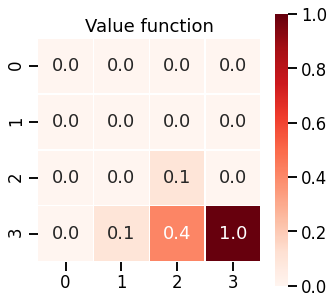

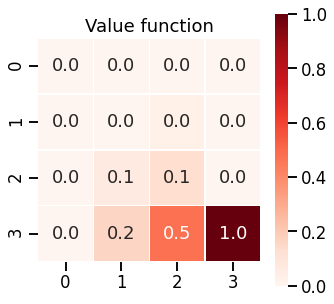

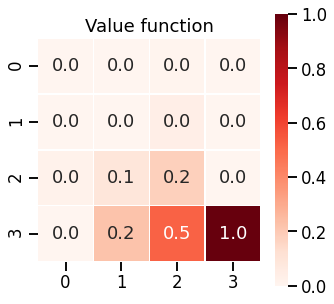

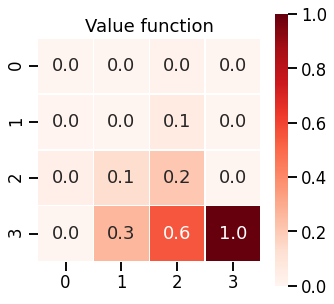

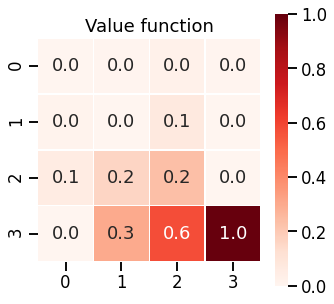

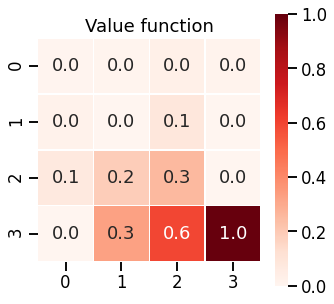

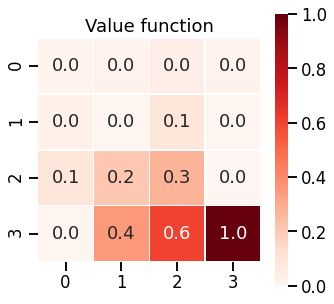

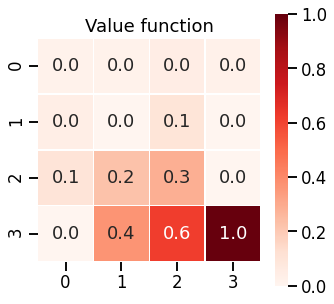

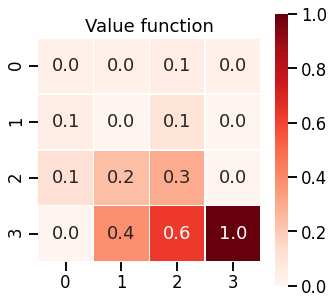

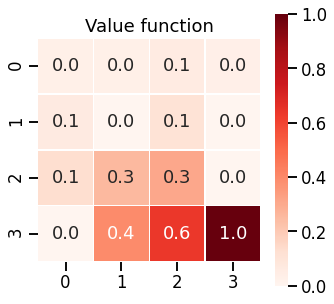

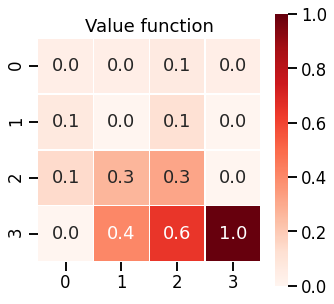

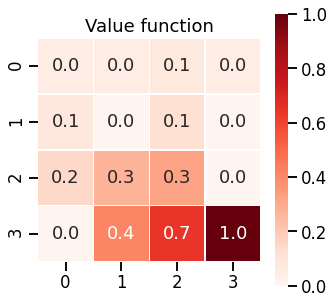

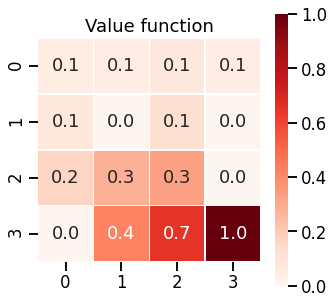

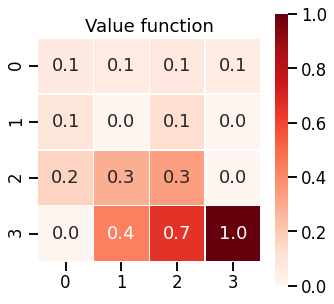

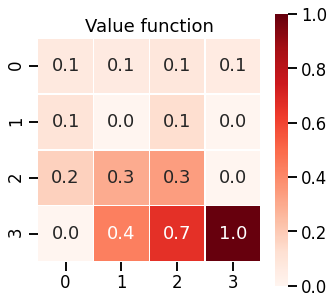

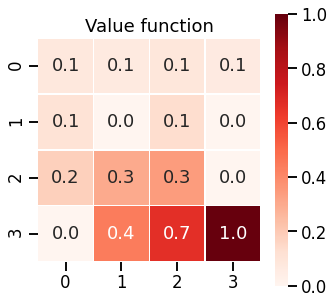

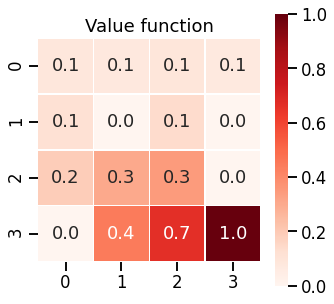

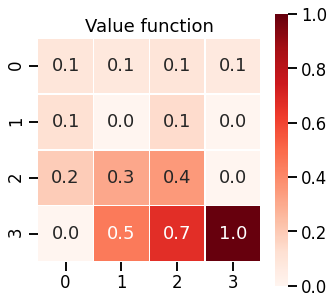

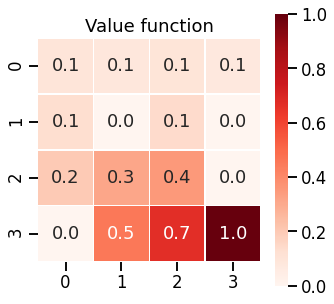

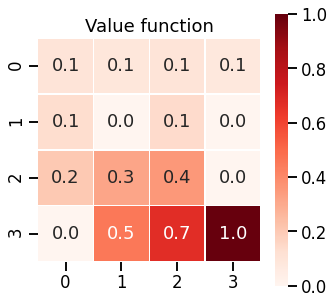

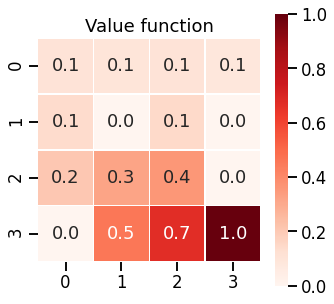

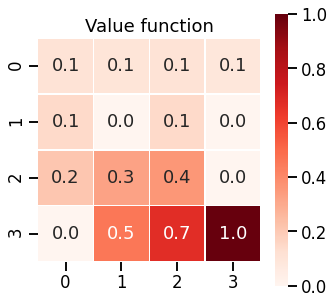

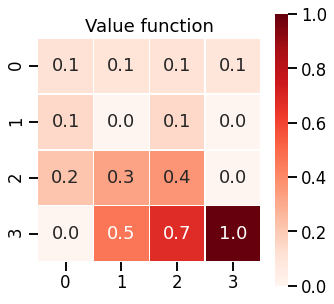

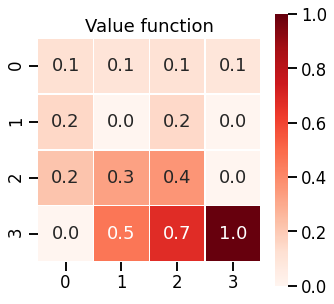

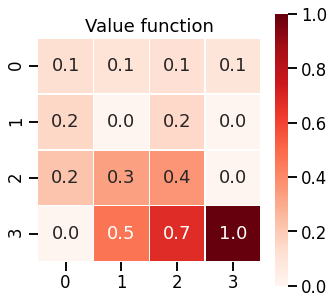

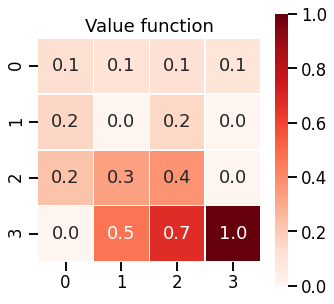

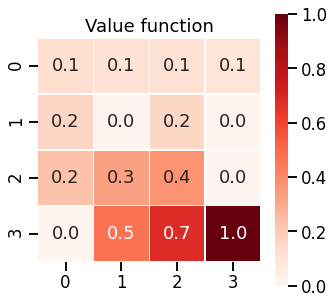

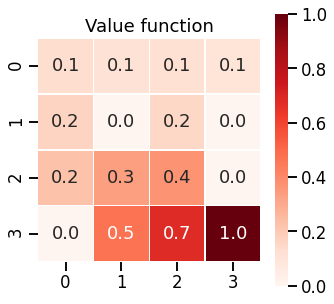

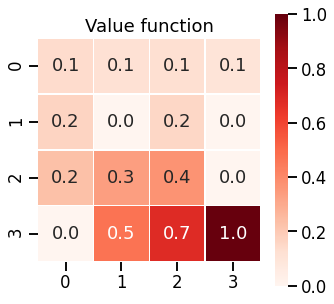

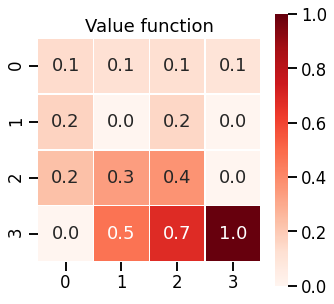

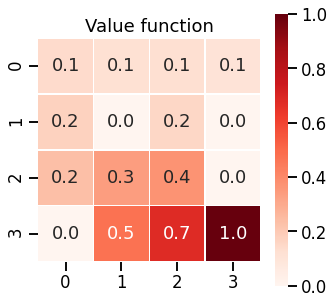

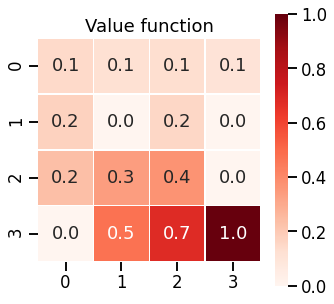

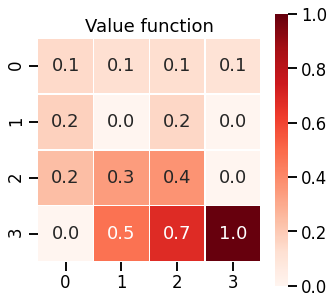

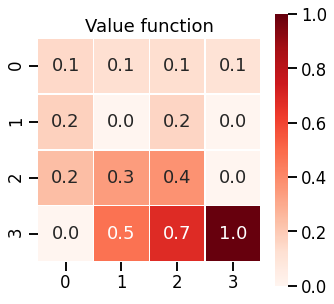

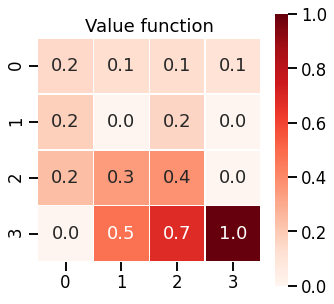

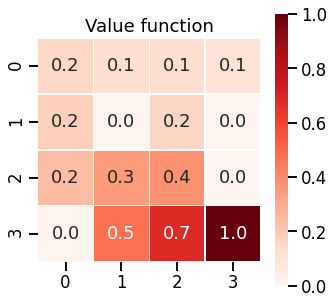

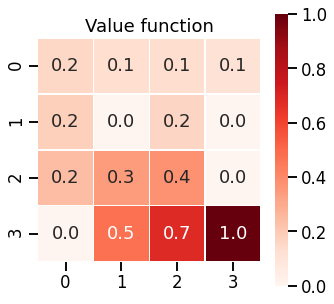

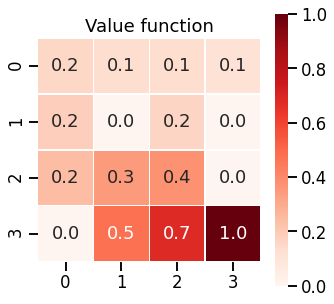

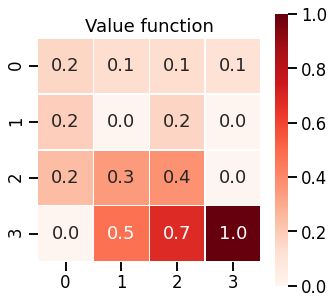

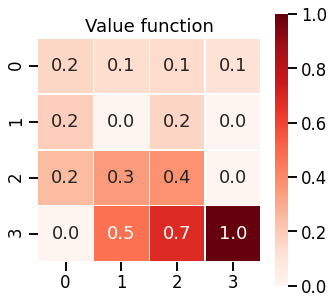

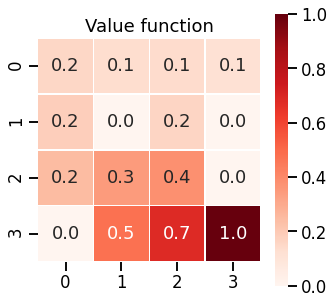

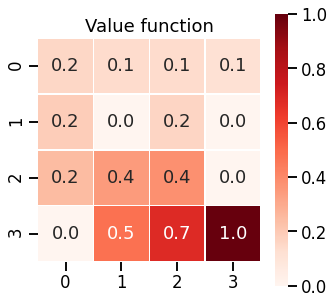

In [24]:
stop = False

value_function_history = []
delta_history = []

def value_iteration(gamma=0.95, epsilon=0.001, display=False):
    v_array = np.zeros(len(states))   # Initial value function
    stop = False

    while not stop:
        if display:
            states_display(v_array, title="Value function", cbar=True, cmap="Reds")
        else:
            print('.', end="")
        value_function_history.append(v_array)
        
        delta = 0.
        expected_list = []
        max_list = []
        v_array_p = v_array.copy()
        
        for state in states:
            if is_final_array[state]:
                v_array_p[state] = reward_array[state]
            else:
                v_array_p[state] = reward_array[state] + gamma * expected_values(state, v_array).max()
        
        max_s = max(abs((v_array_p - v_array)).tolist())
        delta = max(max_s, delta)
        v_array = v_array_p
        
        delta_history.append(delta)
        
        if delta < epsilon:
            stop = True
    
    return v_array
        
v_array = value_iteration(display=True)
states_display(v_array, title="Value function", cbar=True, cmap="Reds")

### Display the evolution of the value function over iterations

In [25]:
df_v_hist = pd.DataFrame(value_function_history)
df_v_hist

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,1.0
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.316667,1.0
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.100278,0.0,0.0,0.100278,0.416944,1.0
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.031755,0.0,0.000000,0.063509,0.132032,0.0,0.0,0.163787,0.480454,1.0
5,0.000000,0.000000,0.010056,0.000000,0.000000,0.0,0.041810,0.0,0.020111,0.093676,0.182311,0.0,0.0,0.224121,0.520676,1.0
6,0.000000,0.003184,0.016424,0.003184,0.006369,0.0,0.060916,0.0,0.036033,0.135072,0.207785,0.0,0.0,0.265517,0.552519,1.0
7,0.003025,0.006209,0.025499,0.007218,0.013427,0.0,0.071000,0.0,0.056200,0.161289,0.237027,0.0,0.0,0.301817,0.575711,1.0
8,0.007176,0.010999,0.032844,0.012646,0.023006,0.0,0.083133,0.0,0.073123,0.188431,0.255867,0.0,0.0,0.328959,0.594551,1.0
9,0.013041,0.016156,0.040731,0.018410,0.032714,0.0,0.091425,0.0,0.090111,0.208351,0.274270,0.0,0.0,0.352114,0.609111,1.0


Evolution of `v_array` (the estimated value of each state) over iterations (one curve per state):

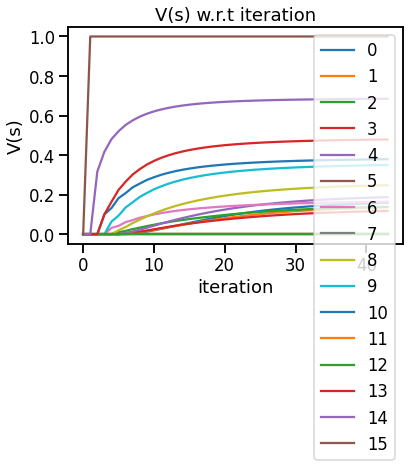

In [26]:
df_v_hist.plot()
plt.title("V(s) w.r.t iteration")
plt.ylabel("V(s)")
plt.xlabel("iteration")
plt.legend(loc='upper right');

Evolution of `delta` over iterations:

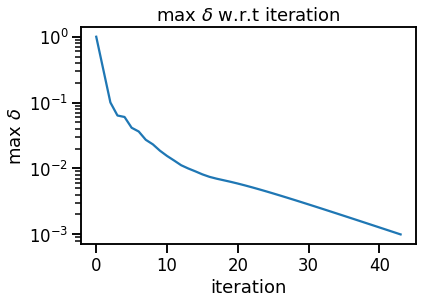

In [27]:
plt.plot(delta_history)
plt.yscale("log")
plt.title(r"$\max~\delta$ w.r.t iteration")
plt.ylabel(r"$\max~\delta$")
plt.xlabel("iteration");

### Question 2: Define the greedy policy (Maximum Expected Utility)

In [28]:
def greedy_policy(state, v_array):
    
    policy = np.argmax(expected_values(state, v_array))
    
    return policy

### Display the opimized policy

Applying the `greedy_policy` on each state gives us the policy matrix:

In [29]:
policy = [greedy_policy(state, v_array) for state in states]

The following cell gives us a graphical representation of the optimal policy we have computed. The figure in each square is the optimal action to execute in the corresponding state (0 = "move left", 1 = "move down", 2 = "move right", 3 = "move up").

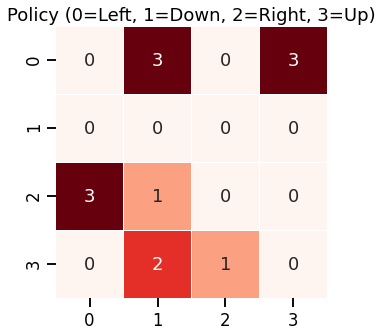

In [30]:
display_policy(policy)

### Evaluate Value Iteration with Gym (single trial)

So far, we have computed the value function `v_array` for one *episode*.
The environment is stochastic, thus if we apply the computed policy several times on the environment, we may have different results.
To measure the performance of our value function `v_array`, we should assess it several times and count the number of successful trials.
OpenAI considers an agent to successfully solve the FrozenLake problem if it reaches 76% success rate over the last 100 trials (or "episodes").

In [31]:
env._max_episode_steps = 1000

In [32]:
reward_list = []

NUM_EPISODES = 1000

for episode_index in range(NUM_EPISODES):
    state = env.reset()
    done = False
    #t = 0

    while not done:
        action = greedy_policy(state, v_array)
        state, reward, done, info = env.step(action)
        #t += 1

    reward_list.append(reward)
    #print("Episode finished after {} timesteps ; reward = {}".format(t, reward))

print(sum(reward_list) / NUM_EPISODES)            

env.close()

0.779


### Question 3: What do you think the discount factor $\gamma$ is for?

The discount rate determines the present value of future rewards. If γ=0, the agent is "myopic" in being concerned only with maximizing the immediate rewards. As γ approaches 1, the return objective takes future rewards into account more strongly.


### Evaluate Value Iteration for different value of $\gamma$ with confidence interval (bootstrap)

In [40]:
%%time

NUM_EPISODES = 1000

reward_list = []

for gamma in (0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.84, 0.9, 0.95, 0.99):
    v_array = value_iteration(gamma=gamma)
    
    for episode_index in range(NUM_EPISODES):
        state = env.reset()
        done = False

        while not done:
            action = greedy_policy(state, v_array)
            state, reward, done, info = env.step(action)

        reward_list.append({"gamma": gamma, "reward": reward})

env.close()

...........................................................................................................................................................................................................................................................Wall time: 6.13 s


In [45]:
df = pd.DataFrame(reward_list)
df.tail()

,gamma,reward
10995,0.99,1.0
10996,0.99,1.0
10997,0.99,1.0
10998,0.99,1.0
10999,0.99,1.0


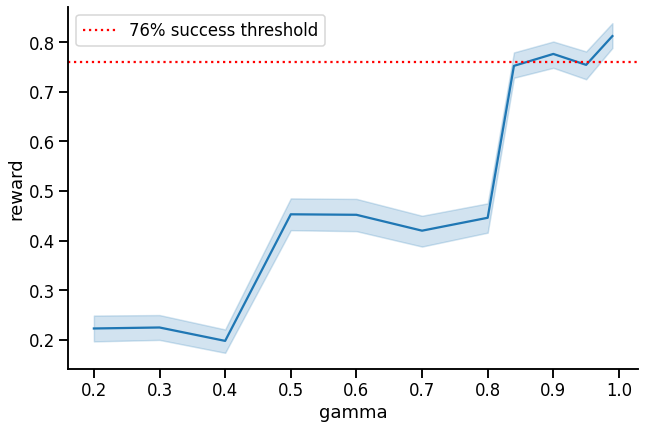

In [43]:
# Plot mean reward (with its 95% confidence interval)

sns.relplot(x="gamma", y="reward", kind="line", data=df, height=6, aspect=1.5)
plt.axhline(0.76, color="red", linestyle=":", label="76% success threshold");   # 76% success threshold
plt.legend();

### Display the Value Iteration optimal policy with respect to $\gamma$


========== GAMMA =  0.2 ==========

....



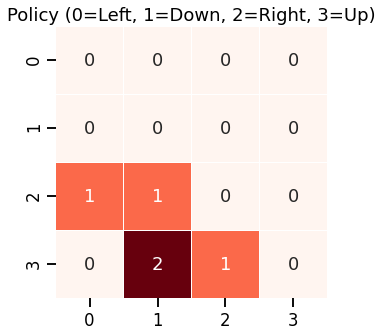


========== GAMMA =  0.3 ==========

.....



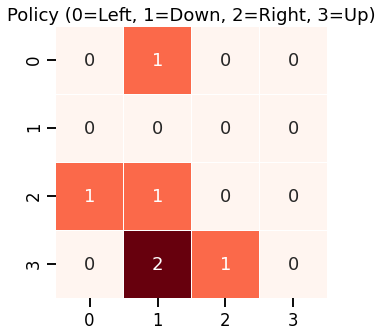


========== GAMMA =  0.4 ==========

......



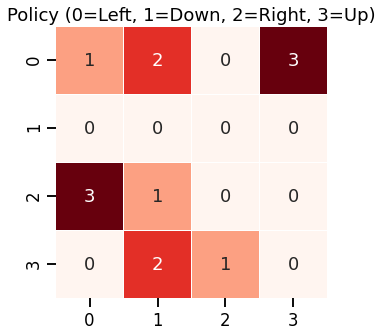


========== GAMMA =  0.5 ==========

.......



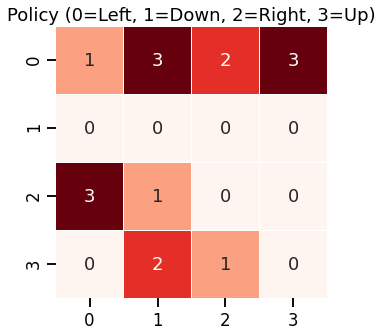


========== GAMMA =  0.6 ==========

.........



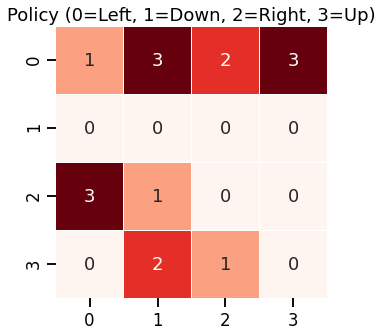


========== GAMMA =  0.7 ==========

...........



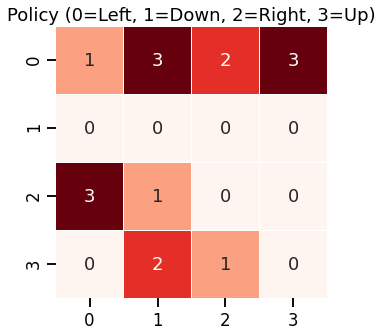


========== GAMMA =  0.8 ==========

...............



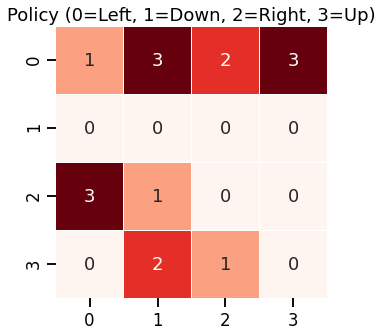


========== GAMMA =  0.84 ==========

..................



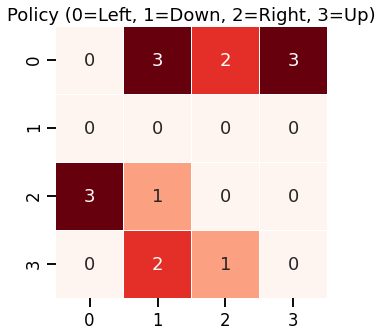


========== GAMMA =  0.9 ==========

...........................



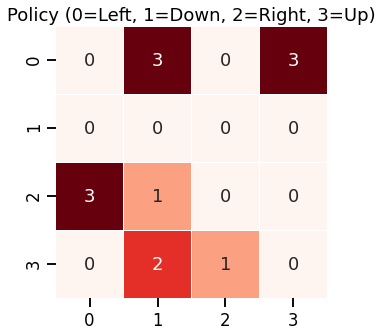


========== GAMMA =  0.95 ==========

............................................



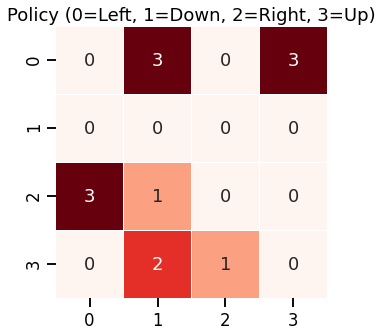


========== GAMMA =  0.99 ==========

.........................................................................................................



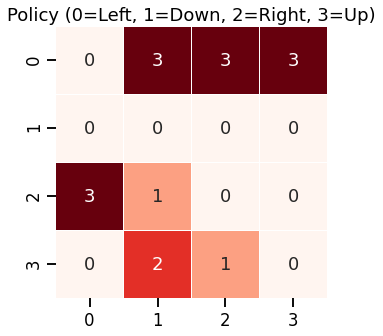

In [47]:
for gamma in (0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.84, 0.9, 0.95, 0.99):
    print()
    print("=" * 10, "GAMMA = ", gamma, "=" * 10)
    print()
    
    v_array = value_iteration(gamma=gamma)
    
    print()
    print()
    
    policy = [greedy_policy(state, v_array) for state in states]
    display_policy(policy)

## References

**[BELLMAN57]** Richard Ernest Bellman. *Dynamic Programming*. Princeton University Press, Princeton,
New Jersey, USA, 1957.

**[HOWARD60]** R.A. Howard. Dynamic Programming and Markov Processes. MIT Press, Cambridge,
Massachusetts, 1960.

In [51]:
%matplotlib??